In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
binding_df_full = pd.read_csv('data/GRB2-SH3.binding.csv')
binding_df = binding_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
abundance_df_full = pd.read_csv('data/GRB2-SH3.abundance.csv')
abundance_df = abundance_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

In [4]:
data_df = binding_df.copy()
y_cols = data_df.columns[1:] 

In [5]:
X = data_df['aa_seq']
y = data_df[y_cols]

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['aa_seq'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=57, Y=2


In [7]:
data_df_GE = binding_df_full[['aa_seq','fitness']].copy()

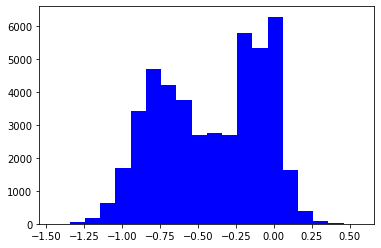

In [8]:
plt.hist(data_df_GE['fitness'],bins=20,color='blue')
plt.show()

In [9]:
#gpmapGE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

gpmapGE = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
                                              alphabet=alphabet,
                                              number_latent_nodes=2)

#gpmapGE = mavenn.gpmap.MultilayerPerceptronGPMap(L, alphabet)
mp_GE = mavenn.measurement_process_layers.GlobalEpsistasisMP(K=50,
                                                           monotonic=True,
                                                           number_latent_nodes=2,
                                                           ge_heteroskedasticity_order=2,
                                                           ge_noise_model_type='Gaussian')

In [10]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train_GE, x_test_GE, y_train_GE, y_test_GE = train_test_split(data_df_GE['aa_seq'].values, 
                                                                data_df_GE['fitness'].values, test_size=0.1)

In [11]:
model_GE = mavenn.Model2(gpmap=gpmapGE,
                      mp_list=[mp_GE])

# Set training data
model_GE.set_data(x=x_train_GE,
               #y_list=[data_df['y'].values.reshape(-1,1)],
               y_list=[y_train_GE.reshape(-1,1)],
               shuffle=False)

2023-01-27 11:44:23.114272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


N = 41,749 observations set as training data.
Using 20.2% for validation.
Time to set data: 1.49 sec.


In [12]:
model_GE.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 1198)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 1197)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 multi__additive_gp_map_layer (  (None, 2)           2396        ['Sequence_only[0][0]']          
 Multi_AdditiveGPMapLayer)                                                                        
                                                                                              

In [13]:
# Fit model to data
history = model_GE.fit(learning_rate=.0005,
                    epochs=250,
                    batch_size=300,
                    try_tqdm=False,
                    early_stopping=False,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/250
112/112 [==============================] - 2s 6ms/step - loss: 295.4451 - I_var: -1.1890 - val_loss: 280.7537 - val_I_var: -1.1257
Epoch 2/250
112/112 [==============================] - 0s 4ms/step - loss: 268.6980 - I_var: -1.0610 - val_loss: 252.4414 - val_I_var: -0.9889
Epoch 3/250
112/112 [==============================] - 0s 4ms/step - loss: 237.6086 - I_var: -0.9097 - val_loss: 217.3757 - val_I_var: -0.8193
Epoch 4/250
112/112 [==============================] - 0s 4ms/step - loss: 199.7941 - I_var: -0.7313 - val_loss: 179.4090 - val_I_var: -0.6356
Epoch 5/250
112/112 [==============================] - 0s 4ms/step - loss: 163.3488 - I_var: -0.5546 - val_loss: 145.3623 - val_I_var: -0.4711
Epoch 6/250
112/112 [==============================] - 0s 4ms/step - loss: 131.2560 - I_var: -0.4019 - val_loss: 117.3706 - val_I_var: -0.3358
Epoch 7/250
112/112 [==============================] - 0s 4ms/step - loss: 103.9582 - I_var: -0.2690 - val_loss: 90.1225 - val_I_var: -0.2039


112/112 [==============================] - 0s 4ms/step - loss: -172.3146 - I_var: 1.0659 - val_loss: -148.7597 - val_I_var: 0.9602
Epoch 59/250
112/112 [==============================] - 0s 4ms/step - loss: -172.7762 - I_var: 1.0637 - val_loss: -150.3130 - val_I_var: 0.9678
Epoch 60/250
112/112 [==============================] - 0s 4ms/step - loss: -173.9075 - I_var: 1.0628 - val_loss: -151.9182 - val_I_var: 0.9757
Epoch 61/250
112/112 [==============================] - 0s 4ms/step - loss: -174.2757 - I_var: 1.0740 - val_loss: -153.1997 - val_I_var: 0.9820
Epoch 62/250
112/112 [==============================] - 1s 6ms/step - loss: -176.6649 - I_var: 1.0860 - val_loss: -142.9838 - val_I_var: 0.9335
Epoch 63/250
112/112 [==============================] - 0s 4ms/step - loss: -176.2426 - I_var: 1.0834 - val_loss: -154.1705 - val_I_var: 0.9871
Epoch 64/250
112/112 [==============================] - 1s 6ms/step - loss: -177.1831 - I_var: 1.0784 - val_loss: -154.9707 - val_I_var: 0.9905
Epoch

Epoch 115/250
112/112 [==============================] - 1s 5ms/step - loss: -184.8150 - I_var: 1.1167 - val_loss: -159.1228 - val_I_var: 1.0113
Epoch 116/250
112/112 [==============================] - 0s 4ms/step - loss: -183.9400 - I_var: 1.1217 - val_loss: -160.7161 - val_I_var: 1.0183
Epoch 117/250
112/112 [==============================] - 0s 4ms/step - loss: -184.8120 - I_var: 1.1271 - val_loss: -158.5533 - val_I_var: 1.0080
Epoch 118/250
112/112 [==============================] - 0s 4ms/step - loss: -184.4289 - I_var: 1.1209 - val_loss: -152.6377 - val_I_var: 0.9790
Epoch 119/250
112/112 [==============================] - 0s 4ms/step - loss: -184.6014 - I_var: 1.1248 - val_loss: -160.9047 - val_I_var: 1.0195
Epoch 120/250
112/112 [==============================] - 0s 4ms/step - loss: -183.4852 - I_var: 1.1124 - val_loss: -160.8511 - val_I_var: 1.0194
Epoch 121/250
112/112 [==============================] - 0s 4ms/step - loss: -184.6365 - I_var: 1.1187 - val_loss: -160.2718 - val

112/112 [==============================] - 0s 4ms/step - loss: -186.9798 - I_var: 1.1323 - val_loss: -162.2541 - val_I_var: 1.0265
Epoch 172/250
112/112 [==============================] - 0s 4ms/step - loss: -187.4589 - I_var: 1.1339 - val_loss: -161.9815 - val_I_var: 1.0254
Epoch 173/250
112/112 [==============================] - 0s 4ms/step - loss: -187.3154 - I_var: 1.1344 - val_loss: -159.9834 - val_I_var: 1.0161
Epoch 174/250
112/112 [==============================] - 0s 4ms/step - loss: -187.3563 - I_var: 1.1373 - val_loss: -162.1391 - val_I_var: 1.0261
Epoch 175/250
112/112 [==============================] - 0s 4ms/step - loss: -187.2565 - I_var: 1.1391 - val_loss: -161.4743 - val_I_var: 1.0227
Epoch 176/250
112/112 [==============================] - 0s 4ms/step - loss: -187.2035 - I_var: 1.1340 - val_loss: -161.1084 - val_I_var: 1.0213
Epoch 177/250
112/112 [==============================] - 0s 4ms/step - loss: -187.5131 - I_var: 1.1335 - val_loss: -160.7835 - val_I_var: 1.0191

112/112 [==============================] - 1s 5ms/step - loss: -188.1861 - I_var: 1.1395 - val_loss: -159.6913 - val_I_var: 1.0149
Epoch 228/250
112/112 [==============================] - 1s 6ms/step - loss: -188.5578 - I_var: 1.1431 - val_loss: -162.9443 - val_I_var: 1.0302
Epoch 229/250
112/112 [==============================] - 1s 6ms/step - loss: -187.9588 - I_var: 1.1427 - val_loss: -163.2155 - val_I_var: 1.0314
Epoch 230/250
112/112 [==============================] - 1s 6ms/step - loss: -188.4522 - I_var: 1.1389 - val_loss: -162.8184 - val_I_var: 1.0295
Epoch 231/250
112/112 [==============================] - 1s 7ms/step - loss: -188.5107 - I_var: 1.1450 - val_loss: -163.2648 - val_I_var: 1.0319
Epoch 232/250
112/112 [==============================] - 0s 4ms/step - loss: -189.0398 - I_var: 1.1470 - val_loss: -158.9878 - val_I_var: 1.0105
Epoch 233/250
112/112 [==============================] - 1s 6ms/step - loss: -188.8918 - I_var: 1.0800 - val_loss: -161.9602 - val_I_var: 1.0250

On test data:


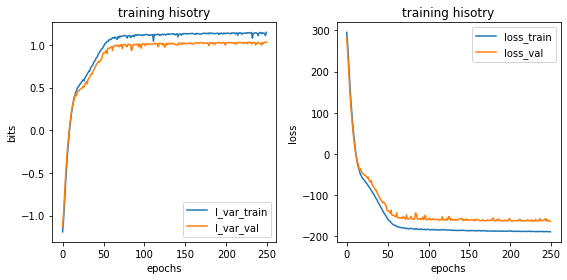

In [14]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_GE.history['I_var']
val_I_var_hist = model_GE.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model_GE.history['loss'], label='loss_train')
ax.plot(model_GE.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [15]:
phi = gpmapGE.x_to_phi(x_test_GE)

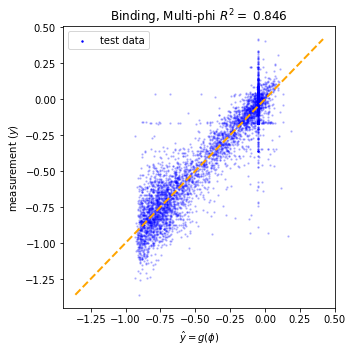

In [16]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

yhat = mp_GE.phi_to_yhat(phi)


lims = [min(min(yhat.numpy().ravel()),min(y_test_GE.ravel())),
        max(max(yhat.numpy().ravel()),max(y_test_GE.ravel()))]

ax.plot(lims,lims,ls='--',color='orange',lw=2)

    
ax.scatter(yhat,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
Rsq = np.corrcoef(yhat.numpy().ravel(),y_test_GE)[0,1]**2

ax.set_xlabel('$\hat{y} = g(\phi)$')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'Binding, Multi-phi $R^2 = $ {Rsq:.3f}')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.tight_layout()
fig.savefig('plots/GRB2_SH3/global_epistasis_binding_multi_phi.png',dpi=300,bbox_inches='tight')    


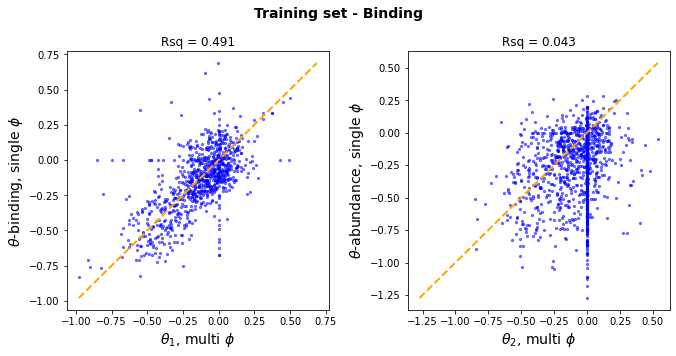

In [36]:
#theta_2_phi[0].shape
fig, axs = plt.subplots(1,2,figsize=(9.5,5))

theta_2_phi = np.squeeze(model_GE.model.layers[2].get_weights()[1])
GE_1_phi_theta_abundance_raw = np.load('model_data/GE_1_phi_theta_abundance_raw.npy')
GE_1_phi_theta_binding_raw = np.load('model_data/GE_1_phi_theta_binding_raw.npy')

ax = axs[0]

lims = [min(min(theta_2_phi[0].ravel()),min(GE_1_phi_theta_binding_raw.ravel())),
        max(max(theta_2_phi[0].ravel()),max(GE_1_phi_theta_binding_raw.ravel()))]

ax.plot(lims,lims,ls='--',color='orange',lw=2)


Rsq = np.corrcoef(theta_2_phi[0].ravel(),GE_1_phi_theta_binding_raw.ravel())[0,1]**2
ax.scatter(theta_2_phi[0],GE_1_phi_theta_binding_raw,s=5,c='blue',alpha=0.5)
ax.set_xlabel('$\\theta_{1}$, multi $\phi$',fontsize=14)
ax.set_ylabel('$\\theta$-binding, single $\phi$',fontsize=14)
ax.set_title(f'Rsq = {Rsq:.3f}')



ax = axs[1]

lims = [min(min(theta_2_phi[1].ravel()),min(GE_1_phi_theta_abundance_raw.ravel())),
        max(max(theta_2_phi[1].ravel()),max(GE_1_phi_theta_abundance_raw.ravel()))]

ax.plot(lims,lims,ls='--',color='orange',lw=2)

Rsq = np.corrcoef(theta_2_phi[1].ravel(),GE_1_phi_theta_abundance_raw.ravel())[0,1]**2
ax.scatter(theta_2_phi[1],GE_1_phi_theta_abundance_raw,s=5,c='blue',alpha=0.5)
ax.set_xlabel('$\\theta_{2}$, multi $\phi$',fontsize=14)
ax.set_ylabel('$\\theta$-abundance, single $\phi$',fontsize=14)
ax.set_title(f'Rsq = {Rsq:.3f}')

fig.suptitle('Training set - Binding',fontweight='bold',fontsize=14)
fig.tight_layout()
fig.savefig('plots/GRB2_SH3/multi_theta_to_single_theta_comparison_binding.png',dpi=300,bbox_inches='tight')  

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(theta_2_lc[0].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[0].set_xlabel('Theta-1 multi-discrete monotonic')
ax[0].set_ylabel('Theta global epistasis')

ax[1].scatter(theta_2_lc[1].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[1].set_xlabel('Theta-2 multi-discrete monotonic')
ax[1].set_ylabel('Theta global epistasis')

fig.tight_layout()

In [ ]:
lehner_binding_singles_df = pd.read_csv('data/GRB2-SH3.singles_binding.csv',index_col=[0])
lehner_binding_singles_df

In [ ]:
binding_singles_transformed_df = pd.DataFrame(np.nan*np.ones(shape=(57,21)),columns=alphabet)
binding_singles_transformed_df.head()

In [ ]:
for idx in lehner_binding_singles_df.index:

    mutant = lehner_binding_singles_df.loc[idx]['Mut']
    value = lehner_binding_singles_df.loc[idx]['fitness']
    
    pos = lehner_binding_singles_df.loc[idx]['Pos']-1
    binding_singles_transformed_df[mutant][pos] = value

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
Rsq = np.corrcoef(theta_2_lc[0].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[0].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 1')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

ax = axs[1]
Rsq = np.corrcoef(theta_2_lc[1].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[1].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 2')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

fig.tight_layout()

#fig.savefig('plots/GRB2_SH3/GRB2_SH3.singles_binding_comparison_to_Lehner.png',dpi=200,bbox_inches='tight')


In [ ]:
# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[12,4])

# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=binding_singles_transformed_df.values,
                        alphabet=alphabet,
                        seq=model.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Lehner - binding')

#fig.savefig('plots/GRB2_SH3/Lehner_GP_map_binding.png',dpi=300,bbox_inches='tight')